### Imports

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import xgboost as xgb

import seaborn as sns
import missingno as mno

### Data load

In [78]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
submission = pd.read_csv("./submission.csv")

### Summarize

In [79]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [80]:
train.describe()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
count,1459.000000,1459.000000,1457.000000,1457.000000,1450.000000,1457.000000,1457.000000,1383.000000,1369.000000,1342.000000,1459.000000
mean,1105.914325,11.493489,16.717433,0.031572,2.479034,52.231297,1405.216884,0.039149,57.168736,30.327124,108.563400
std,631.338681,6.922790,5.239150,0.174917,1.378265,20.370387,583.131708,0.019509,31.771019,14.713252,82.631733
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,555.500000,5.500000,12.800000,0.000000,1.400000,36.000000,879.000000,0.025500,36.000000,20.000000,37.000000
50%,1115.000000,11.000000,16.600000,0.000000,2.300000,51.000000,1577.000000,0.039000,51.000000,26.000000,96.000000
75%,1651.000000,17.500000,20.100000,0.000000,3.400000,69.000000,1994.000000,0.052000,69.000000,37.000000,150.000000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,269.000000,90.000000,431.000000


In [81]:
train_X = train.drop('count', axis=1)
train_y = train['count']

test_X = test

### Cleaning

In [82]:
train_X.pop('id')
test_X.pop('id')

0         0
1         1
2         2
3         4
4         5
       ... 
710    2148
711    2149
712    2165
713    2166
714    2177
Name: id, Length: 715, dtype: int64

In [83]:
train_X = train_X.astype({'hour_bef_precipitation' : 'bool'})
test_X = test_X.astype({'hour_bef_precipitation' : 'bool'})

### Scaling (Z-score)

In [84]:
scaler = StandardScaler()

cat_features = train_X.select_dtypes('bool').columns
num_features = train_X.select_dtypes(['int', 'float']).columns


train_X = pd.concat([pd.DataFrame(scaler.fit_transform(train_X[num_features]), columns = train_X[num_features].columns), train_X[cat_features]], axis=1)
test_X = pd.concat([pd.DataFrame(scaler.transform(test_X[num_features]), columns = test_X[num_features].columns), test_X[cat_features]], axis=1)


test_X.describe()


,hour,hour_bef_temperature,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
count,715.000000,714.000000,714.000000,714.000000,714.000000,680.000000,678.000000,679.000000
mean,-0.003000,1.249844,-0.065699,0.217880,-0.078435,0.104943,-0.637230,-0.366303
std,1.001157,0.771315,0.850108,0.965550,1.053592,1.059164,0.398040,0.685070
min,-1.660809,-0.404295,-1.799283,-1.779237,-2.194455,-1.853561,-1.516676,-1.586041
25%,-0.866059,0.684042,-0.710583,-0.502436,-1.025793,-0.622945,-0.918428,-0.906128
50%,-0.071309,1.180476,-0.129943,0.135965,0.143727,-0.007638,-0.698021,-0.430189
75%,0.795691,1.843979,0.577712,1.056735,1.020331,0.671765,-0.383154,0.045750
max,1.662690,3.261680,2.482937,2.345812,1.020331,5.068651,1.159696,2.629418


### Data Visualization

array([[<AxesSubplot: ylabel='Frequency'>,
        <AxesSubplot: ylabel='Frequency'>,
        <AxesSubplot: ylabel='Frequency'>,
        <AxesSubplot: ylabel='Frequency'>,
        <AxesSubplot: ylabel='Frequency'>],
       [<AxesSubplot: ylabel='Frequency'>,
        <AxesSubplot: ylabel='Frequency'>,
        <AxesSubplot: ylabel='Frequency'>,
        <AxesSubplot: ylabel='Frequency'>,
        <AxesSubplot: ylabel='Frequency'>]], dtype=object)

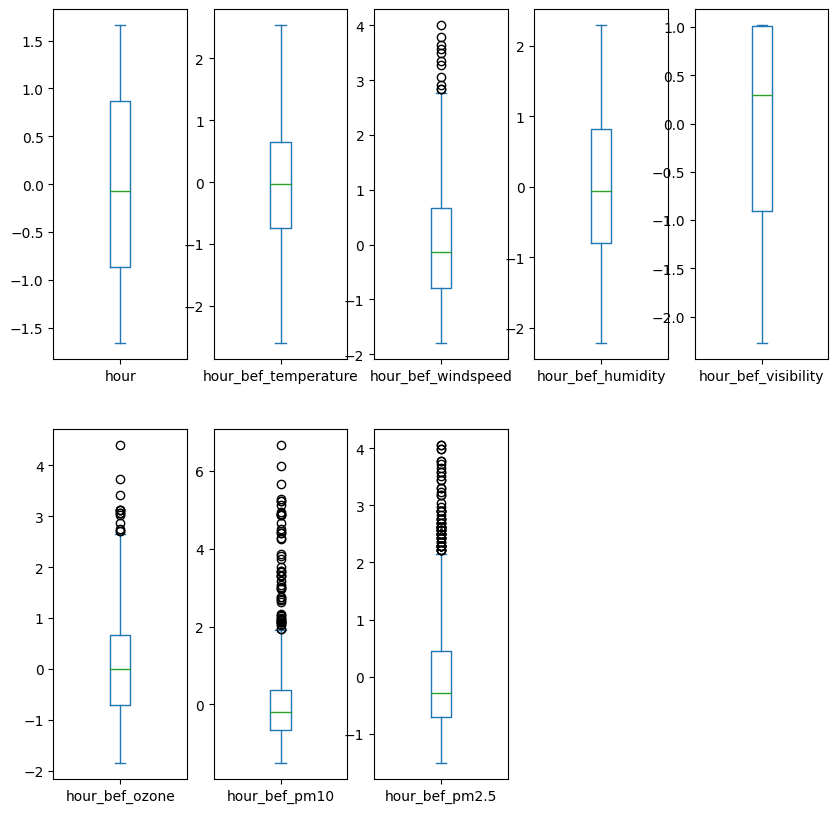

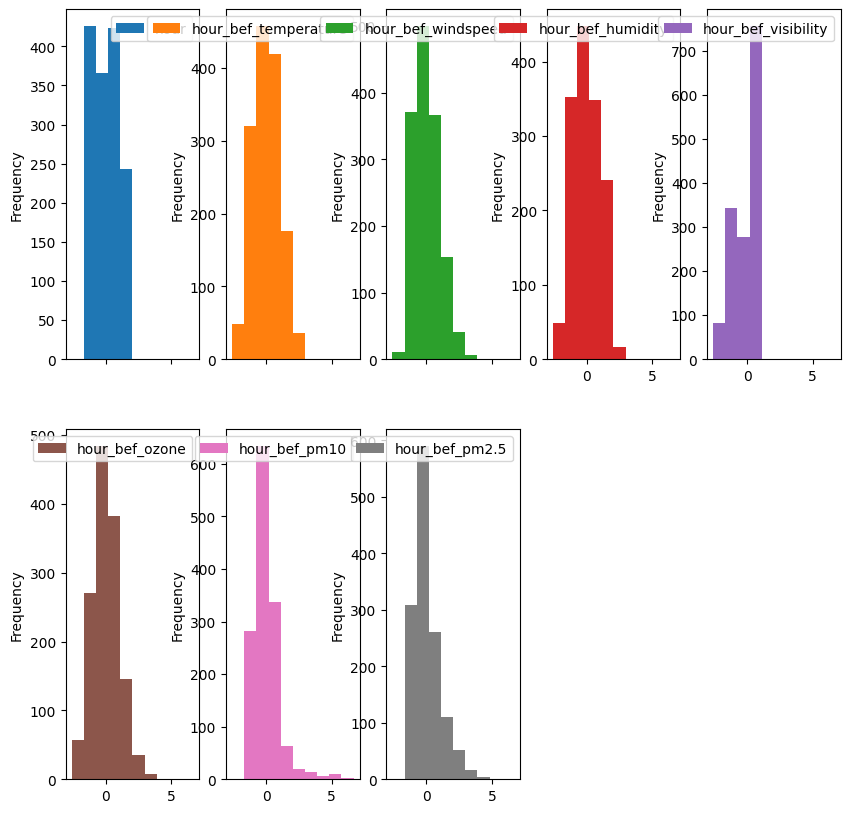

In [85]:
train_X.plot(kind = "box", subplots = True, layout=(2, 5), figsize = (10, 10))
train_X.plot(kind = "hist", bins = 10, subplots = True, layout = (2, 5), figsize = (10, 10))

### Handling missing values

In [86]:
train_X.isna().sum() / train.shape[0]

hour                      0.000000
hour_bef_temperature      0.001371
hour_bef_windspeed        0.006169
hour_bef_humidity         0.001371
hour_bef_visibility       0.001371
hour_bef_ozone            0.052090
hour_bef_pm10             0.061686
hour_bef_pm2.5            0.080192
hour_bef_precipitation    0.000000
dtype: float64

<AxesSubplot: >

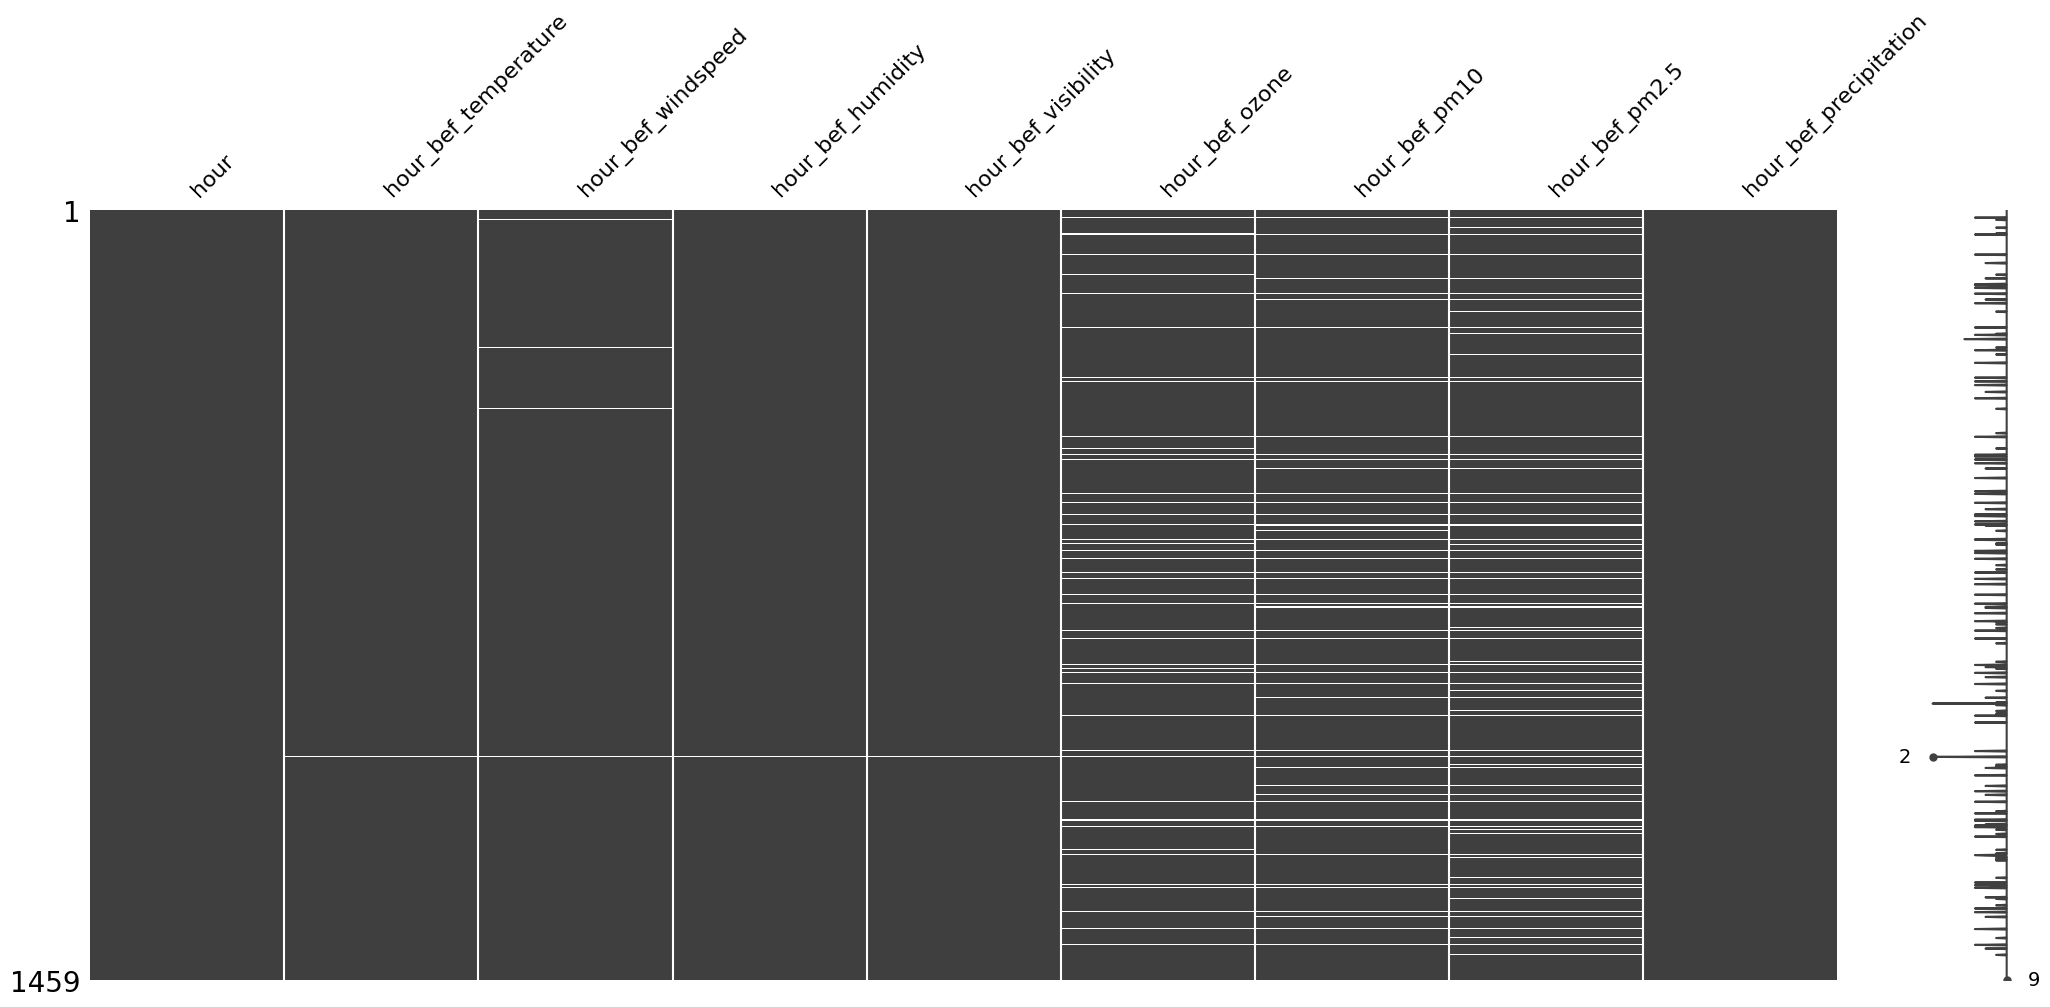

In [87]:
mno.matrix(train_X)

In [88]:
# 한번에 처리
'''
num_imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

train_X[num_features] = num_imputer.fit_transform(train_X[num_features])
test_X[num_features] = num_imputer.transform(test_X[num_features])
'''

# hour group 별로 처리
train_X = train_X.groupby('hour').apply(lambda g: g.fillna(g.mean()))
test_X = test_X.groupby('hour').apply(lambda g: g.fillna(g.mean()))

train_X.isna().sum()

/tmp/ipykernel_338/3411798285.py:10: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  train_X = train_X.groupby('hour').apply(lambda g: g.fillna(g.mean()))
/tmp/ipykernel_338/3411798285.py:11: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  test_X = test_X.groupby('hour').apply(lambda g: g.fillna(g.m

hour                       0
hour_bef_temperature       0
hour_bef_windspeed         0
hour_bef_humidity          0
hour_bef_visibility        0
hour_bef_ozone            61
hour_bef_pm10             61
hour_bef_pm2.5            61
hour_bef_precipitation     0
dtype: int64

### Encoding

In [89]:
oh_enc = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

oh_train = pd.DataFrame(oh_enc.fit_transform(train_X['hour'].to_frame()))
oh_test = pd.DataFrame(oh_enc.transform(test_X['hour'].to_frame()))

train_X.pop('hour')
test_X.pop('hour')

train_X = pd.concat([train_X, oh_train], axis=1)
test_X = pd.concat([test_X, oh_test], axis=1)

train_X.head()

,hour_bef_temperature,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,hour_bef_precipitation,0,1,...,13,14,15,16,17,18,19,20,21,22
0,-0.079703,-0.710583,1.805627,-1.422494,-0.622945,0.592935,0.181732,True,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.645854,-0.783163,-0.207789,-0.839236,0.146189,0.498475,0.657671,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.537950,-1.291223,1.314550,-0.039828,-0.315291,-0.792481,-0.770146,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.645380,0.160377,0.086857,-0.787772,0.043638,0.561448,2.289462,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2.440655,1.684557,-2.221206,1.020331,0.915324,-0.949915,-1.314076,False,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Models and Scoring

In [90]:
def score_dataset(X, y, model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1)):
    score = cross_val_score(
        model, X, y, cv=5, scoring = 'neg_root_mean_squared_error'
    )
    return -1*score

In [91]:
print(score_dataset(train_X, train_y).mean())

41.41188891270876


In [92]:
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(train_X, train_y)
predict = model.predict(test_X)
submission['count'] = predict
submission

,id,count
0,0,121.603432
1,1,139.078629
2,2,36.117332
3,4,100.469467
4,5,63.916080
...,...,...
710,2148,70.764252
711,2149,56.208702
712,2165,109.431686
713,2166,139.205276


### Submission

In [93]:
submission.to_csv("submission.csv", index = False)